In [1]:
import time
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from harp_beam import compute_EEPs
from functions import to_dBV, stefcal, stefcal_optimised
from plots import plot2

In [2]:
# set random seed
np.random.seed(12042000)

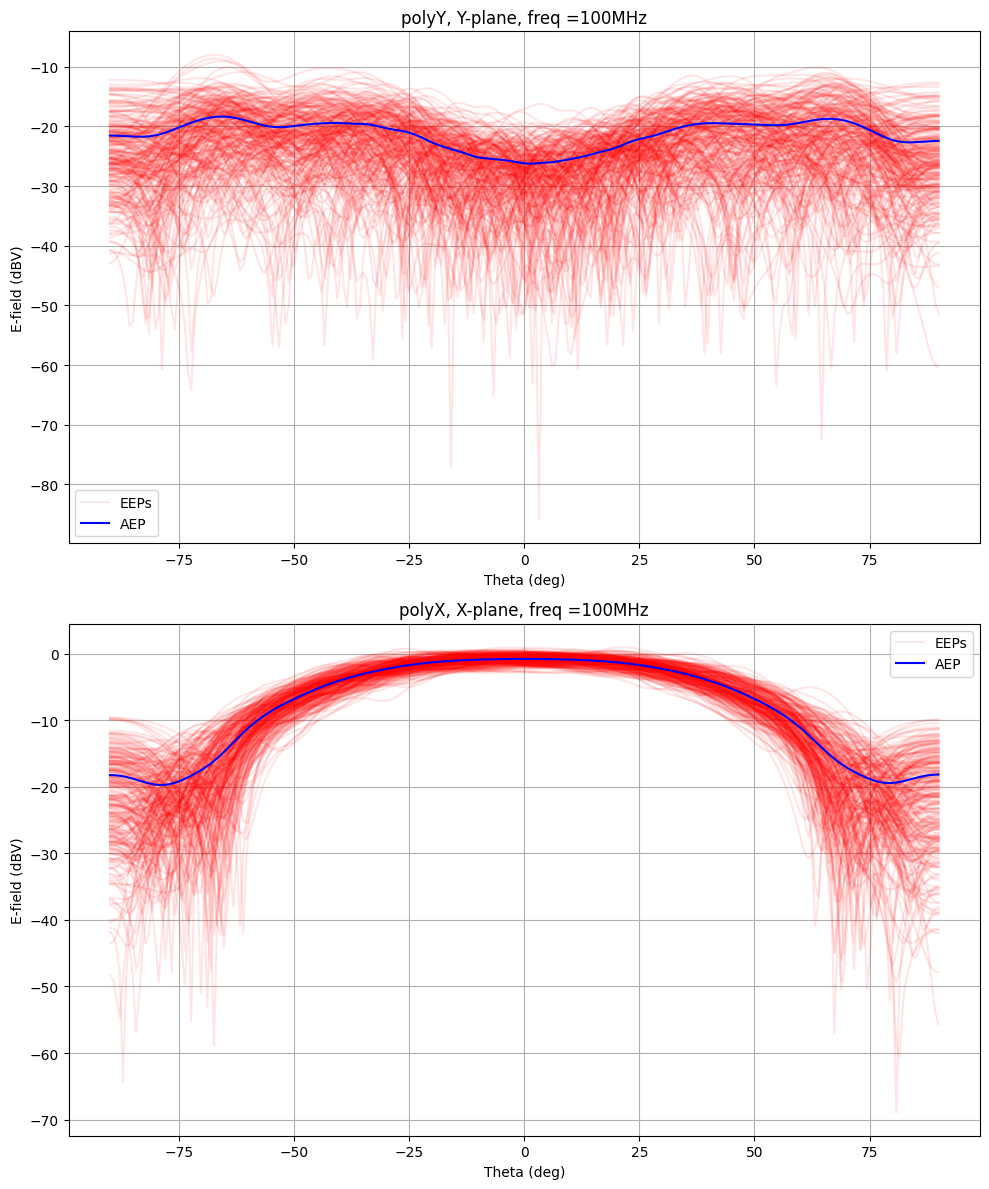

In [93]:
## Q 2. plot all the 256 EEPs and their average (AEP)
num_dir = 256
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = np.zeros_like(theta)

# Compute EEPs
v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Calculate magnitude of EEPs in dBV
magnitude_EEP_polY = to_dBV(np.abs(v_theta_polY))
magnitude_EEP_polX = to_dBV(np.abs(v_theta_polX))

# Calculate AEPs
AEP_polY = to_dBV(np.sqrt(np.mean(np.abs(v_theta_polY)**2, axis=1)))
AEP_polX = to_dBV(np.sqrt(np.mean(np.abs(v_theta_polX)**2, axis=1)))

# plot EEPs and AEPs
plot2(theta, v_theta_polY, v_theta_polX, magnitude_EEP_polY, magnitude_EEP_polX, AEP_polY, AEP_polX)

In [4]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs


In [91]:
# Q 5.

# Step 1 Calibration

v_calibrated_EEP_polY = v_theta_polY / g_EEPs
v_calibrated_EEP_polX = v_theta_polX / g_EEPs
v_calibrated_AEP_polY = v_theta_polY / g_AEP
v_calibrated_AEP_polX = v_theta_polX / g_AEP

# Step 2 
# Convert to dBV for magnitude of Y polarization
magnitude_calibrated_EEP_polY_dBV = to_dBV(np.abs(v_calibrated_EEP_polY))
magnitude_calibrated_AEP_polY_dBV = to_dBV(np.abs(v_calibrated_AEP_polY))

# Convert to dBV for magnitude of X polarization
magnitude_calibrated_EEP_polX_dBV = to_dBV(np.abs(v_calibrated_EEP_polX))
magnitude_calibrated_AEP_polX_dBV = to_dBV(np.abs(v_calibrated_AEP_polX))


# Step 3 Beamforming
v_beamformed_EEP_polY = np.sum(v_calibrated_EEP_polY, axis=0) # ensure the correct axis is summed if needed
v_beamformed_EEP_polX = np.sum(v_calibrated_EEP_polX, axis=0)
v_beamformed_AEP_polY = np.sum(v_calibrated_AEP_polY, axis=0)
v_beamformed_AEP_polX = np.sum(v_calibrated_AEP_polX, axis=0)

# Step 4 Power
power_beamformed_EEP_polY_dBV = to_dBV(np.abs(v_beamformed_EEP_polY)**2)
power_beamformed_AEP_polY_dBV = to_dBV(np.abs(v_beamformed_AEP_polY)**2)
power_beamformed_EEP_polX_dBV = to_dBV(np.abs(v_beamformed_EEP_polX)**2)
power_beamformed_AEP_polX_dBV = to_dBV(np.abs(v_beamformed_AEP_polX)**2)

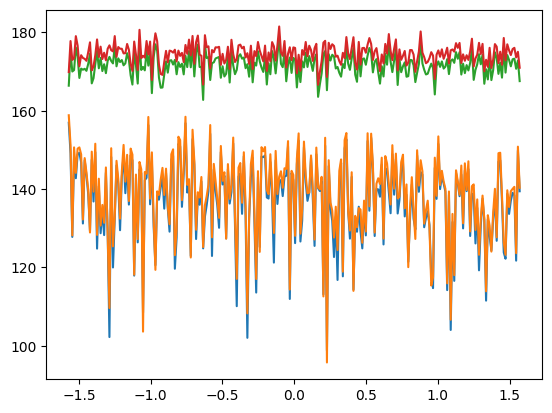

In [94]:
# plotting
plt.plot(theta, power_beamformed_EEP_polY_dBV, label='power_beamformed_EEP_polY_dBV')
plt.plot(theta, power_beamformed_AEP_polY_dBV, label='power_beamformed_AEP_polY_dBV')
plt.plot(theta, power_beamformed_EEP_polX_dBV, label='power_beamformed_EEP_polX_dBV')
plt.plot(theta, power_beamformed_AEP_polX_dBV, label='power_beamformed_AEP_polX_dBV')

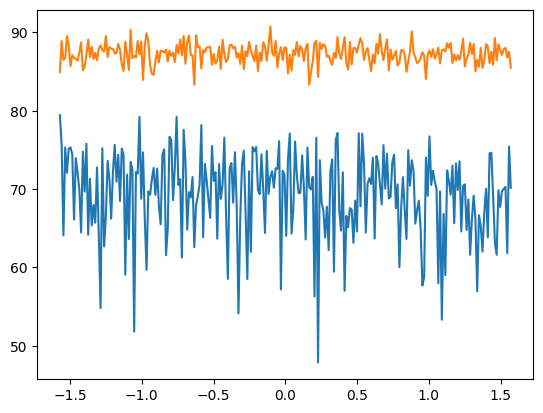

In [98]:
# Step 1: Calibrate the EEP voltages
v_calibrated_theta_polY = v_theta_polY / g_AEP
v_calibrated_theta_polX = v_theta_polX / g_AEP

# Step 2: Beamform the calibrated voltages
# Summing across the elements (assuming no phase adjustment needed)
v_beamformed_polY = np.sum(v_calibrated_theta_polY, axis=0)
v_beamformed_polX = np.sum(v_calibrated_theta_polX, axis=0)

# Step 3: Convert beamformed voltages to dBV
beamformed_polY_dBV = to_dBV(np.abs(v_beamformed_polY))
beamformed_polX_dBV = to_dBV(np.abs(v_beamformed_polX))


# Step 4: Plot the beamformed voltages
plt.plot(theta, beamformed_polY_dBV, label='beamformed_polY_dBV')
plt.plot(theta, beamformed_polX_dBV, label='beamformed_polX_dBV')


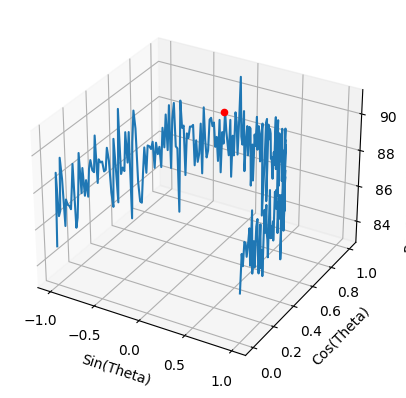

In [100]:
from mpl_toolkits.mplot3d import Axes3D

x = np.sin(theta)
y = np.cos(theta)
z = beamformed_polX_dBV

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the beam pattern as a line in the phi = 0 plane
ax.plot(x, y, z)

# Set labels
ax.set_xlabel('Sin(Theta)')
ax.set_ylabel('Cos(Theta)')
ax.set_zlabel('Response (Arbitrary Units)')

# mark the steering direction
# Convert the steering direction to sine-cosine coordinates
steering_theta, steering_phi = np.radians(40), np.radians(80)
steering_x = np.sin(steering_theta) * np.cos(steering_phi)
steering_y = np.sin(steering_theta) * np.sin(steering_phi)

# Mark the steering direction on the plot
ax.scatter([steering_x], [steering_y], [max(z)], color='red')

# Show the plot
plt.show()